In [3]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import warnings 

In [4]:
domain = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters', 
                                      'alaska_vic_domain_ncar.nc'))

(209, 299)


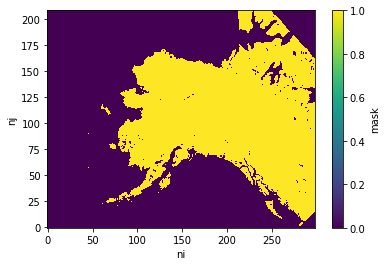

In [5]:
domain.mask.plot()
print(domain.mask.shape)

In [7]:
root_depth_file = xr.open_mfdataset(os.path.join('/u/home/gergel/data/parameters/vars_4d', 
                                                 'root_depth*'),
                                            concat_dim='root_zone', 
                                            data_vars='all', 
                                            coords='all')

In [8]:
root_depth = xr.concat([root_depth_file['root_depth'].isel(veg_class=11),
                             root_depth_file['root_depth'].isel(veg_class=0),
                             root_depth_file['root_depth'].isel(veg_class=0),
                             root_depth_file['root_depth'].isel(veg_class=1),
                             root_depth_file['root_depth'].isel(veg_class=2),
                             root_depth_file['root_depth'].isel(veg_class=2),
                             root_depth_file['root_depth'].isel(veg_class=3),
                             root_depth_file['root_depth'].isel(veg_class=3),
                             root_depth_file['root_depth'].isel(veg_class=3),
                             root_depth_file['root_depth'].isel(veg_class=8),
                             root_depth_file['root_depth'].isel(veg_class=8),
                             root_depth_file['root_depth'].isel(veg_class=8),
                             root_depth_file['root_depth'].isel(veg_class=9),
                             root_depth_file['root_depth'].isel(veg_class=9),
                             root_depth_file['root_depth'].isel(veg_class=9),
                             root_depth_file['root_depth'].isel(veg_class=10),
                             root_depth_file['root_depth'].isel(veg_class=2)], 
                            dim='veg_class')

In [9]:
root_fract_file = xr.open_mfdataset(os.path.join('/u/home/gergel/data/parameters/vars_4d', 
                                                 'root_fract*'),
                                            concat_dim='root_zone', 
                                            data_vars='all', 
                                            coords='all')

In [10]:
var = "root_fract"
root_fract = xr.concat([root_fract_file[var].isel(veg_class=11),
                             root_fract_file[var].isel(veg_class=0),
                             root_fract_file[var].isel(veg_class=0),
                             root_fract_file[var].isel(veg_class=1),
                             root_fract_file[var].isel(veg_class=2),
                             root_fract_file[var].isel(veg_class=2),
                             root_fract_file[var].isel(veg_class=3),
                             root_fract_file[var].isel(veg_class=3),
                             root_fract_file[var].isel(veg_class=3),
                             root_fract_file[var].isel(veg_class=8),
                             root_fract_file[var].isel(veg_class=8),
                             root_fract_file[var].isel(veg_class=8),
                             root_fract_file[var].isel(veg_class=9),
                             root_fract_file[var].isel(veg_class=9),
                             root_fract_file[var].isel(veg_class=9),
                             root_fract_file[var].isel(veg_class=10),
                             root_fract_file[var].isel(veg_class=2)], 
                            dim='veg_class')

In [11]:
albedo_file = xr.open_mfdataset(os.path.join('/u/home/gergel/data/parameters/vars_4d', 
                                                 'albedo*'),
                                            concat_dim='month', 
                                            data_vars='all', 
                                            coords='all')

In [12]:
var = "albedo"
albedo = xr.concat([albedo_file[var].isel(veg_class=11),
                             albedo_file[var].isel(veg_class=0),
                             albedo_file[var].isel(veg_class=0),
                             albedo_file[var].isel(veg_class=1),
                             albedo_file[var].isel(veg_class=2),
                             albedo_file[var].isel(veg_class=2),
                             albedo_file[var].isel(veg_class=3),
                             albedo_file[var].isel(veg_class=3),
                             albedo_file[var].isel(veg_class=3),
                             albedo_file[var].isel(veg_class=8),
                             albedo_file[var].isel(veg_class=8),
                             albedo_file[var].isel(veg_class=8),
                             albedo_file[var].isel(veg_class=9),
                             albedo_file[var].isel(veg_class=9),
                             albedo_file[var].isel(veg_class=9),
                             albedo_file[var].isel(veg_class=10),
                             albedo_file[var].isel(veg_class=2)], 
                            dim='veg_class')

In [13]:
# load regridded PFTs 
pfts_data_dir = '/u/home/gergel/data/parameters/pfts/regridded_pfts'
pfts_filename = 'mksrf_landuse_rc2000_c110913_ncar.nc'
veg_data = xr.open_dataset(os.path.join(pfts_data_dir, pfts_filename))

In [14]:
def calculate_cv_pft(gridcell_pft):
    '''
    takes a percent PFT for a gridcell and returns the fraction of gridcell coverage for that PFT
    '''
    
    return(gridcell_pft / 100.0)

In [15]:
cv = xr.apply_ufunc(calculate_cv_pft, 
                    veg_data['PCT_PFT'].where(domain.mask == 1),
                    dask='allowed',
                    vectorize=True)

In [16]:
def calculate_nveg_pfts(gridcell_pfts):
    '''
    takes in the 17 PFTs for a gridcell and returns the number of active veg types for that gridcell,
    e.g. the number of PCT_PFTs that is greater than 0
    '''
    return(np.count_nonzero(gridcell_pfts))

In [17]:
Nveg = xr.apply_ufunc(calculate_nveg_pfts,
                      veg_data['PCT_PFT'].where(domain.mask == 1),
                      dask='allowed',
                      input_core_dims=[['pft']],
                      vectorize=True)

In [18]:
lai_file = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/lai/regridded_lai', 
                                   'mksrf_lai_78pfts_simyr2005.c170413_ncar_lai.nc'))
veg_height_file = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/lai/regridded_lai', 
                                'mksrf_lai_78pfts_simyr2005.c170413_ncar_veg_height.nc'))

In [19]:
lai_slice = lai_file['MONTHLY_LAI'].isel(pft = 0)
vegheight_slice = veg_height_file['MONTHLY_HEIGHT_TOP'].isel(pft=0)

lai = xr.concat([lai_file['MONTHLY_LAI'], lai_slice], dim='pft')
veg_height = xr.concat([veg_height_file['MONTHLY_HEIGHT_TOP'], vegheight_slice], dim='pft')

In [20]:
veg_rough = 0.123 * veg_height
displacement = 0.67 * veg_height

In [21]:
def map_pft_to_nldas_class(pft):
    '''
    this function takes in a pft and maps it to an NLDAS veg class for using NLDAS VIC 5 veg-class 
    specific parameters. 
    '''
    # bare 
    if pft == 0:
        nldas = 11
    # NET - temperate
    elif pft == 1:
        nldas = 0
    # NET - boreal
    elif pft == 2:
        nldas = 0
    # NDT - boreal
    elif pft == 3:
        nldas = 1
    # BET - tropical
    elif pft == 4:
        nldas = 2
    # BET - temperate
    elif pft == 5:
        nldas = 2
    # BDT - tropical
    elif pft == 6:
        nldas = 3
    # BDT - temperate
    elif pft == 7:
        nldas = 3
    # BDT - boreal
    elif pft == 8:
        nldas = 3
    # BES - temperate
    elif pft == 9:
        nldas = 8
    # BDS - temperate
    elif pft == 10:
        nldas = 8
    # BDS - boreal
    elif pft == 11:
        nldas = 8
    # C3 arctic grass
    elif pft == 12:
        nldas = 9
    # C3 grass
    elif pft == 13:
        nldas = 9
    # C4 grass
    elif pft == 14:
        nldas = 9
    # crops
    elif pft == 15:
        nldas = 10
    elif pft == 16: 
        nldas = 2
    else: 
        raise ValueError("this is not a PFT")
    return(nldas)

In [22]:
old_params = xr.open_dataset(os.path.join('/u/home/gergel/data', 
                                          'vic_params_wr50a_vic5.0.dev_20160328.nc'))

In [23]:
# masknan_vals = domain['mask'].where(domain['mask'] == 1).values
masknan_vals = domain['mask'].values
nj = 209
ni = 299
num_veg = 17


arr_months = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                    masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                    masknan_vals, masknan_vals, masknan_vals, masknan_vals)), 
                        axis=2)
arr_nlayer = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals)), 
                        axis=2)

arr_rootzone = np.rollaxis(np.dstack((masknan_vals, masknan_vals)), 
                        axis=2)

arr_veg_classes = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals)), 
                              axis=2)
arr_veg_classes_rootzone = np.vstack((arr_rootzone, arr_rootzone, arr_rootzone, arr_rootzone, 
                                      arr_rootzone, arr_rootzone, arr_rootzone, arr_rootzone, 
                                      arr_rootzone, arr_rootzone, arr_rootzone, arr_rootzone, 
                                      arr_rootzone, arr_rootzone, arr_rootzone,
                                      arr_rootzone, arr_rootzone)).reshape(num_veg, 2, nj, ni)
arr_veg_classes_month = np.vstack((arr_months, arr_months, arr_months, arr_months, arr_months, 
                                   arr_months, arr_months, arr_months, arr_months, arr_months, 
                                   arr_months, arr_months, arr_months, arr_months, arr_months, 
                                   arr_months, arr_months,)).reshape(num_veg, 12, nj, ni)

In [24]:
from netCDF4 import default_fillvals

params = xr.Dataset()

# define fillvals
fillval_f = default_fillvals['f8']
fillval_i = default_fillvals['i4']

params['Cv'] = xr.DataArray(cv,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Fraction of grid cell covered by vegetation tile",
                                        'units': "fraction", 'long_name': "Cv"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['Nveg'] = xr.DataArray(Nveg,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "Number of vegetation tiles in the grid cell", 
                                          'units': "N/A", 'long_name': "Nveg"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

params['trunk_ratio'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Ratio of total tree height that is trunk \
                                 (no branches) \
                                        The default value has been 0.2",
                                 'units': "fraction", 'long_name': "Cv"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['rarc'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Architectural resistance of vegetation type \(~2 s/m)",
                                        'units': "s/m", 'long_name': "rarc"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
                                     

params['rmin'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Minimum stomatal resistance of vegetation type (~100 s/m)"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['wind_h'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Height at which wind speed is measured",
                                        'units': "m", 'long_name': "wind_h"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['RGL'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Minimum incoming shortwave radiation at which there will be \
                                        transpiration. For trees this is about 30 W/m^2, for crops about 100 W/m^2",
                                        'units': "W/m^2", 'long_name': "RGL"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['rad_atten'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Radiation attenuation factor. Normally set to 0.5, though may \
                                        need to be adjusted for high latitudes",
                                        'units': "fraction", 'long_name': "rad_atten"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['wind_atten'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Wind speed attenuation through the overstory. The default value \
                                        has been 0.5",
                                        'units': "fraction", 'long_name': "wind_atten"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['root_depth'] = xr.DataArray(root_depth.values,
                                         dims=('veg_class','root_zone','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Root zone thickness (sum of depths is total depth of \
                                                 root penetration)",
                                                'units': "m", 'long_name': "root_depth"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['root_fract'] = xr.DataArray(root_fract.values,
                                         dims=('veg_class','root_zone','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Fraction of root in the current root zone",
                                                'units': "fraction", 'long_name': "root_fract"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['albedo'] = xr.DataArray(albedo.values,
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Shortwave albedo for vegetation type",
                                                'units': "fraction", 'long_name': "albedo"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['LAI'] = xr.DataArray(lai.values.reshape(num_veg, 12, nj, ni),
                                 dims=('veg_class','month','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc, 'month': old_params.month},
                                 attrs={'description': "Leaf Area Index, one per month",
                                        'units': "N/A", 'long_name': "LAI"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['overstory'] = xr.DataArray(arr_veg_classes,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Flag to indicate whether or not the current vegetation type \
                                        has an overstory (TRUE for overstory present (e.g. trees), FALSE for \
                                        overstory not present (e.g. grass))",
                                        'units': "N/A", 'long_name': "overstory"},
                                 encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params['displacement'] = xr.DataArray(displacement.values.reshape(num_veg, 12, nj, ni), 
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'month': old_params['month'], 'xc': domain.xc, 
                                                 'yc': domain.yc},
                                         attrs={'description': "Vegetation displacement height (typically 0.67 \
                                                * vegetation height)",
                                                'units': "m", 'long_name': "displacement"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['veg_rough'] = xr.DataArray(veg_rough.values.reshape(num_veg, 12, nj, ni),
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Vegetation roughness length (typically 0.123 \
                                                * vegetation height)",
                                                'units': "m", 'long_name': "veg_rough"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [25]:
# trunk ratio, rarc, rad_atten
trunk_ratio = np.copy(arr_veg_classes)
params['trunk_ratio'].values = trunk_ratio * 0.2
rarc = np.copy(arr_veg_classes)
params['rarc'].values = rarc * 60
rad_atten = np.copy(arr_veg_classes)
params['rad_atten'].values = rad_atten * 0.5
wind_atten = np.copy(arr_veg_classes)
params['wind_atten'].values = wind_atten * 0.5

In [26]:
# rmin, wind_h
for pft in veg_data.pft.values:
    # get nldas mapping from pft
    nldas = map_pft_to_nldas_class(pft)
    if nldas >= 0 and nldas <= 3:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=0).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=0).mean())
    elif nldas == 4:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=4).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=4).mean())
    elif nldas >= 5 and nldas <= 6:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=5).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=5).mean())
    elif nldas >= 7 and nldas <= 8:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=7).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=7).mean())
    elif nldas == 9:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=9).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=9).mean())
    elif nldas == 10:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=10).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=10).mean())
    elif nldas == 11:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=11).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=11).mean())
    params['rmin'][pft, :, :] = arr_veg_classes[pft, :, :] * rmin
    params['wind_h'][pft, :, :] = arr_veg_classes[pft, :, :] * wind_h

In [27]:
# RGL
for pft in veg_data.pft.values:
    # get nldas mapping from pft
    nldas = map_pft_to_nldas_class(pft)
    if nldas >= 0 and nldas <= 3:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=0).mean())
    elif nldas >= 4 and nldas <= 5:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=4).mean())
    elif nldas >= 6 and nldas <= 8:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=6).mean())
    elif nldas >= 9 and nldas <= 10:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=9).mean())
    elif nldas == 11:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=11).mean())
    params['RGL'][pft, :, :] = arr_veg_classes[pft, :, :] * rgl

In [28]:
# overstory
for pft in veg_data.pft.values:
    nldas = map_pft_to_nldas_class(pft)
    if nldas > 6:
        # no overstory
        overstory = 0
    else: 
        overstory = 1
    params['overstory'][pft, :, :] = arr_veg_classes[pft, :, :] * overstory

In [31]:
# adjust data vars that need adjusting 
params['Nveg'].values = params['Nveg'].where(domain.mask == 1)
params['trunk_ratio'] = params['trunk_ratio'].where(domain.mask == 1)
params['rarc'] = params['rarc'].where(domain.mask == 1)
params['rmin'] = params['rmin'].where(domain.mask == 1)
params['wind_h'] = params['wind_h'].where(domain.mask == 1)
params['RGL'] = params['RGL'].where(domain.mask == 1)
params['rad_atten'] = params['rad_atten'].where(domain.mask == 1)
params['wind_atten'] = params['wind_atten'].where(domain.mask == 1)
params['root_depth'] = params['root_depth'].where(domain.mask == 1)
params['root_fract'] = params['root_fract'].where(domain.mask == 1)
params['albedo'] = params['albedo'].where(domain.mask == 1)
params['LAI'] = params['LAI'].where(domain.mask == 1)
params['overstory'] = params['overstory'].where(domain.mask == 1)
params['displacement'] = params['displacement'].where(domain.mask == 1)
params['veg_rough'] = params['veg_rough'].where(domain.mask == 1)

In [32]:
params

<xarray.Dataset>
Dimensions:       (month: 12, ni: 299, nj: 209, root_zone: 2, veg_class: 17)
Coordinates:
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    xc            (nj, ni) float64 -173.9 -173.7 -173.6 -173.4 -173.3 -173.2 ...
    yc            (nj, ni) float64 49.87 49.91 49.95 49.99 50.03 50.07 50.11 ...
Dimensions without coordinates: ni, nj, root_zone, veg_class
Data variables:
    Cv            (veg_class, nj, ni) float64 nan nan nan nan nan nan nan ...
    Nveg          (nj, ni) float64 nan nan nan nan nan nan nan nan nan nan ...
    trunk_ratio   (veg_class, nj, ni) float64 nan nan nan nan nan nan nan ...
    rarc          (veg_class, nj, ni) float64 nan nan nan nan nan nan nan ...
    rmin          (veg_class, nj, ni) float64 nan nan nan nan nan nan nan ...
    wind_h        (veg_class, nj, ni) float64 nan nan nan nan nan nan nan ...
    RGL           (veg_class, nj, ni) float64 nan nan nan nan nan nan nan ...
    rad_atten     (veg_class, nj, ni) float64 na

In [33]:
encoding_params = {'Nveg': {'dtype': 'int32', "_FillValue": fillval_i},
                   'overstory': {'dtype': 'int32', "_FillValue": fillval_i}}
direc = '/u/home/gergel/data/parameters'
new_params_file = os.path.join(direc, 'veg_params_ncar_alaska.nc')
params.to_netcdf(new_params_file, format='NETCDF4_CLASSIC', encoding=encoding_params)